In [14]:
path_no = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/'
path_yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/'

import keras
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

countt=0
no = []
yes = []
for dirname, _, filenames in os.walk(path_no):
    for filename in filenames:
        img_path  = os.path.join(dirname,filename)
        img = image.load_img(img_path, target_size=(224, 224,3))
        x_img = image.img_to_array(img)
        x_img = np.expand_dims(x_img, axis=0)
        x_imp = preprocess_input(x_img)
        no.append(x_img[0])
        
n = len(no)
n

98

In [17]:
countt = 0
for dirname, _, filenames in os.walk(path_yes):
    for filename in filenames:
        img_path  = os.path.join(dirname,filename)
        try:
            img = image.load_img(img_path, target_size=(224, 224,3))
            x_img = image.img_to_array(img)
            x_img = np.expand_dims(x_img, axis=0)
            x_imp = preprocess_input(x_img)
            if x_img is not None:
                yes.append(x_img[0])
                countt+=1
                if countt==n:
                    break
        except:
            print(f"Error processing image {img_path}")

In [19]:
no_array = np.array(no)
yes_array = np.array(yes)

combined_array = np.concatenate((yes, no), axis=0)

print(combined_array.shape)

(196, 224, 224, 3)


In [20]:
sz1 = n
sz2 = n

array1 = np.array([1])
array2 = np.array([0])

repeated_array1 = np.tile(array1, (sz1, 1))
repeated_array2 = np.tile(array2, (sz2, 1))

result_array = np.concatenate((repeated_array1, repeated_array2), axis=0)

print(result_array.shape)

(196, 1)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_array, result_array, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (156, 224, 224, 3)
X_test shape: (40, 224, 224, 3)
y_train shape: (156, 1)
y_test shape: (40, 1)


In [23]:
yt = 0
nt = 0
for y in y_train:
    if y[0]==1:
        yt += 1
    elif y[0]==0:
        nt += 1
        
print(f"yes images = {yt}\nno images = {nt}\ntotal images = {yt+nt}")

yes images = 77
no images = 79
total images = 156


(224, 224, 3)
[1]


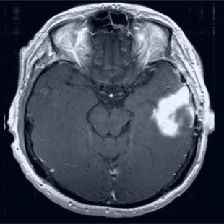

In [24]:
print(X_train[0].shape)
print(y_train[0])
keras.utils.array_to_img(X_train[0])

In [25]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Load the pre-trained VGG model without the top (fully connected) layers
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Create a new model with the VGG base model's input and output
vgg = Model(inputs=base_model.input, outputs=base_model.output)

# Load weights from the H5 file
vgg.load_weights('/kaggle/input/vgg16-weights-tf-keras/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [31]:
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers

x = GlobalAveragePooling2D()(vgg.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,              # Random rotation by 0 to 20 degrees
    horizontal_flip=True,           # Random horizontal flipping
    vertical_flip=True,             # Random vertical flipping
    width_shift_range=0.1,          # Random width shifting by 10% of total width
    height_shift_range=0.1,         # Random height shifting by 10% of total height
    shear_range=0.1,                # Shear intensity by 0.1 radians
    zoom_range=0.1,                 # Random zooming by 10%
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_test, y_test,
    batch_size=32
)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 169s 32s/step - accuracy: 0.4766 - loss: 2.1224 - val_accuracy: 0.6250 - val_loss: 0.9781 - learning_rate: 1.0000e-05
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 161s 32s/step - accuracy: 0.6550 - loss: 1.1003 - val_accuracy: 0.7000 - val_loss: 0.8411 - learning_rate: 1.0000e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 163s 33s/step - accuracy: 0.7030 - loss: 0.8966 - val_accuracy: 0.6750 - val_loss: 0.8510 - learning_rate: 1.0000e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 200s 32s/step - accuracy: 0.7013 - loss: 0.7550 - val_accuracy: 0.7500 - val_loss: 0.8088 - learning_rate: 1.0000e-05
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 161s 32s/step - accuracy: 0.6490 - loss: 0.8851 - val_accuracy: 0.7000 - val_loss: 0.7023 - learning_rate: 1.0000e-05
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 202s 32s/step - accuracy: 0.6633 - loss: 0.8288 - val_accuracy: 0.7500 - val_loss: 0.7533 - learning_rate: 1.0000e-05
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 208s 33s/step - accuracy: 0.8139 - loss: 0.5914 - v

In [35]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7667 - loss: 0.6397
Test Loss: 0.6316306591033936
Test Accuracy: 0.7749999761581421


In [36]:
img_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x_img = image.img_to_array(img)
x_img = np.expand_dims(x_img, axis=0)
x_imp = preprocess_input(x_img)

features = model.predict(x_img)

features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.9862709]], dtype=float32)

In [37]:
img_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/1 no.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x_img = image.img_to_array(img)
x_img = np.expand_dims(x_img, axis=0)
x_imp = preprocess_input(x_img)

features = model.predict(x_img)

features

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


array([[0.09056189]], dtype=float32)